# File Loading 

Loads each dataset and splits them into columns as the original csv files only has one column of data separated by spaces. I also import the necessary libraries and functions for the analysis, choosing to use sklearn instead of scipy for AgglomerativeClustering because I wanted to use its silhouette score function to quantitatively analyse the quality of the cluster fits, such that I can iteratively optimise my parameters easily.

(Note that in order for the code to run correctly, the dataset files must be in the same folder as the jupyter notebook file)

In [106]:
import os

# When doing KMeans I was getting a warning for memory leaks before setting this variable to 3
os.environ["OMP_NUM_THREADS"] = "2"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

folder_path = os.getcwd()

# Process the datasets into separate columns
def split_vector_columns(datasets):
    cols_to_split = []
    for col in datasets.columns:
        if datasets[col].dtype == object:
            sample = datasets[col].dropna().iloc[0]
            if isinstance(sample, str) and ' ' in sample:
                cols_to_split.append(col)
    for col in cols_to_split:
        new_cols = datasets[col].str.split(expand=True)
        new_cols = new_cols.astype(float)
        new_cols.columns = [f"{col}_{i}" for i in range(new_cols.shape[1])]
        datasets = datasets.drop(columns=[col])
        datasets = pd.concat([datasets, new_cols], axis=1)

    return datasets


# Clustering Approaches

Before applying the clustering methods to our datasets, I will briefly explain how each algorithm functions and when they should be used. 

Hierachical agglomerative clustering groups datapoints from the ground up, starting with n observations and grouping them into k clusters iteratively joining together the data points which are closest together in distance. It can use either single/complete/average/medoid linkage as criterion to gauge distance. Single uses the distance between the two closest points in two individual clusters, complete uses the maximum distance, average computes the average distance between all combinations of pairs in the two clusters while medoid calculates the distance between the medoids of the two clusters. It can effectively identify clusters of any shape.

K-Means clustering groups data points by selecting k points and clustering data based on which of the k points they are closest to, calculating new centre points for the resultant clusters and regrouping the data based on these points. This is done iteratively until the algorithm stops, usually once the clusters stop changing and the output is stable. It is most effective at identifying spherical and even clusters.

DBScan clusters datapoints based on density rather than distance like the two previous methods, grouping together data based on how many other points are in a chosen radius around them. If a datapoints has a threshold number of points surrounding it, it is classified as a core point and data within its chosen radius are in the same cluster as it. Core points within the radius of each other and their respective clustered points aggregrate into one cluster. It is best for identifying clusters of roughly constant density, but they may be of any shape. It is also resistant to noise, unlike the other two methods.

All algorithms struggle more with clusters that are closer together or not well-separated.

# Data Set 1

#### Parameter Tuning

First I load the dataset being used and process the data to a NumPy array for ease of use. I then iteratively determined the optimal parameters for each clustering technique using the silhouette scores for each method as a performance indicator to maximise. For DBScan I gave a large range of values over which were suitable to test. I used this parameter tuning method on every dataset evaluated. 

I have no medoid plots for agglomerative clustering as I could neither find this method in the sklearn or scipy AG clustering functions.

In [107]:
file = 'Dataset_1.csv'
print(f"Processing dataset: {file}")

# Construct full file path and load the CSV using pandas.
file_path = os.path.join(folder_path, file)

dataset = pd.read_csv(file, header=None)

print("Original shape:", dataset.shape)

# Split up vector columns
dataset = split_vector_columns(dataset)
print("Processed shape:", dataset.shape)

# Convert dataset to a numpy array
data = dataset.values

# Select the data for cluster
X = data[:, :-1]
true_labels = data[:, -1]

# Standardise the data to centre it at the origin
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hierarchical Clustering Optimisation

# Determine the optimal number of clusters and hierarchical clustering method by iterating k in range 2 -> 11 and determining the optimal k-value based on the highest silhouette score obtained
silhouette_scores0 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='average')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores0.append(score)
optimal_k = np.argmax(silhouette_scores0) + 2 
print(f"Optimal number of clusters (Agglomerative, average linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores0[optimal_k-2]:.3f}")

silhouette_scores1 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='single')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores1.append(score)
optimal_k = np.argmax(silhouette_scores1) + 2  
print(f"Optimal number of clusters (Agglomerative, single linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores1[optimal_k-2]:.3f}")

silhouette_scores2 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='complete')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores2.append(score)
optimal_k = np.argmax(silhouette_scores2) + 2  
print(f"Optimal number of clusters (Agglomerative, complete linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores2[optimal_k-2]:.3f}")


# K-Means Clustering Optimisation

# Same methodology as for hierarchical clustering optimisation

silhouette_scores3 = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores3.append(score)
Kmeans_k = np.argmax(silhouette_scores3) + 2  
print(f"Optimal number of clusters (K-means) for {file}: {Kmeans_k} " \
      f"with silhouette score: {silhouette_scores3[Kmeans_k-2]:.3f}")

# DBScan, parameters are again with an iterative method but this time over two parameters

# Define ranges for eps and min_samples to iterate over
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
min_samples_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# List of results for each iteration (eps, min_samples, silhouette_score)
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)

        # Only calc score for iterations with >1 cluster group

        unique_labels = np.unique(labels)
        if len(unique_labels) > 1 and (len(unique_labels) > 2 or -1 not in unique_labels): 
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1  #If only 1 cluster is found (same as original dataset)
        dbscan_results.append((eps, min_samples, score))

# Identify the optimal parameters (with the highest silhouette score)
best_params = max(dbscan_results, key=lambda x: x[2])
print(f"Optimal DBSCAN parameters for {file}: eps = {best_params[0]}, min_samples = {best_params[1]}, silhouette score = {best_params[2]:.3f}")



Processing dataset: Dataset_1.csv
Original shape: (600, 1)
Processed shape: (600, 3)
Optimal number of clusters (Agglomerative, average linkage) for Dataset_1.csv: 9 with silhouette score: 0.508
Optimal number of clusters (Agglomerative, single linkage) for Dataset_1.csv: 2 with silhouette score: -0.026
Optimal number of clusters (Agglomerative, complete linkage) for Dataset_1.csv: 6 with silhouette score: 0.511
Optimal number of clusters (K-means) for Dataset_1.csv: 5 with silhouette score: 0.499
Optimal DBSCAN parameters for Dataset_1.csv: eps = 0.2, min_samples = 3, silhouette score = 0.444


Having obtained the optimal parameters for each method, I select the best agglomerative clustering method with the highest silhouette score (here it is complete linkage with k = 6) and manually change the code parameters for the final plots. The k-means and DBScan parameters are already set automatically through the code. 

However, for dataset 1 (and dataset 5 as you will see later) this method of optimising the parameters proved ineffective for the DBScan technique and produced inaccurate plots when compared to the data. Therefore, I tried an alternative method of optimising the DBScan parameters, selecting the value for epsilon using a k-distance graph as seen below, however this also did not work. 

Text(0.5, 1.0, 'Avg distance 0.10612698924525588')

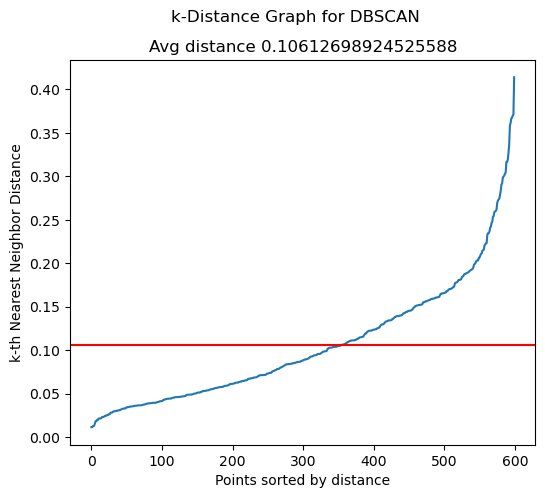

In [108]:
from sklearn.neighbors import NearestNeighbors

# k-distance graph to help select eps
minpts = 3
neighbors = NearestNeighbors(n_neighbors=minpts)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
# sort distances (take the 4th nearest neighbor distance)
distances = np.sort(distances[:, minpts-1])

plt.figure(figsize=(6, 5))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-th Nearest Neighbor Distance')
plt.suptitle('k-Distance Graph for DBSCAN')
plt.axhline(y = np.mean(distances), c = "red")
plt.title("Avg distance {}".format(np.mean(distances)))

Utimately, I manually tested different values of epsilon for the DBScan graph, and 0.3 with minPts set to 3 proved to be quite effective for classifying the data.

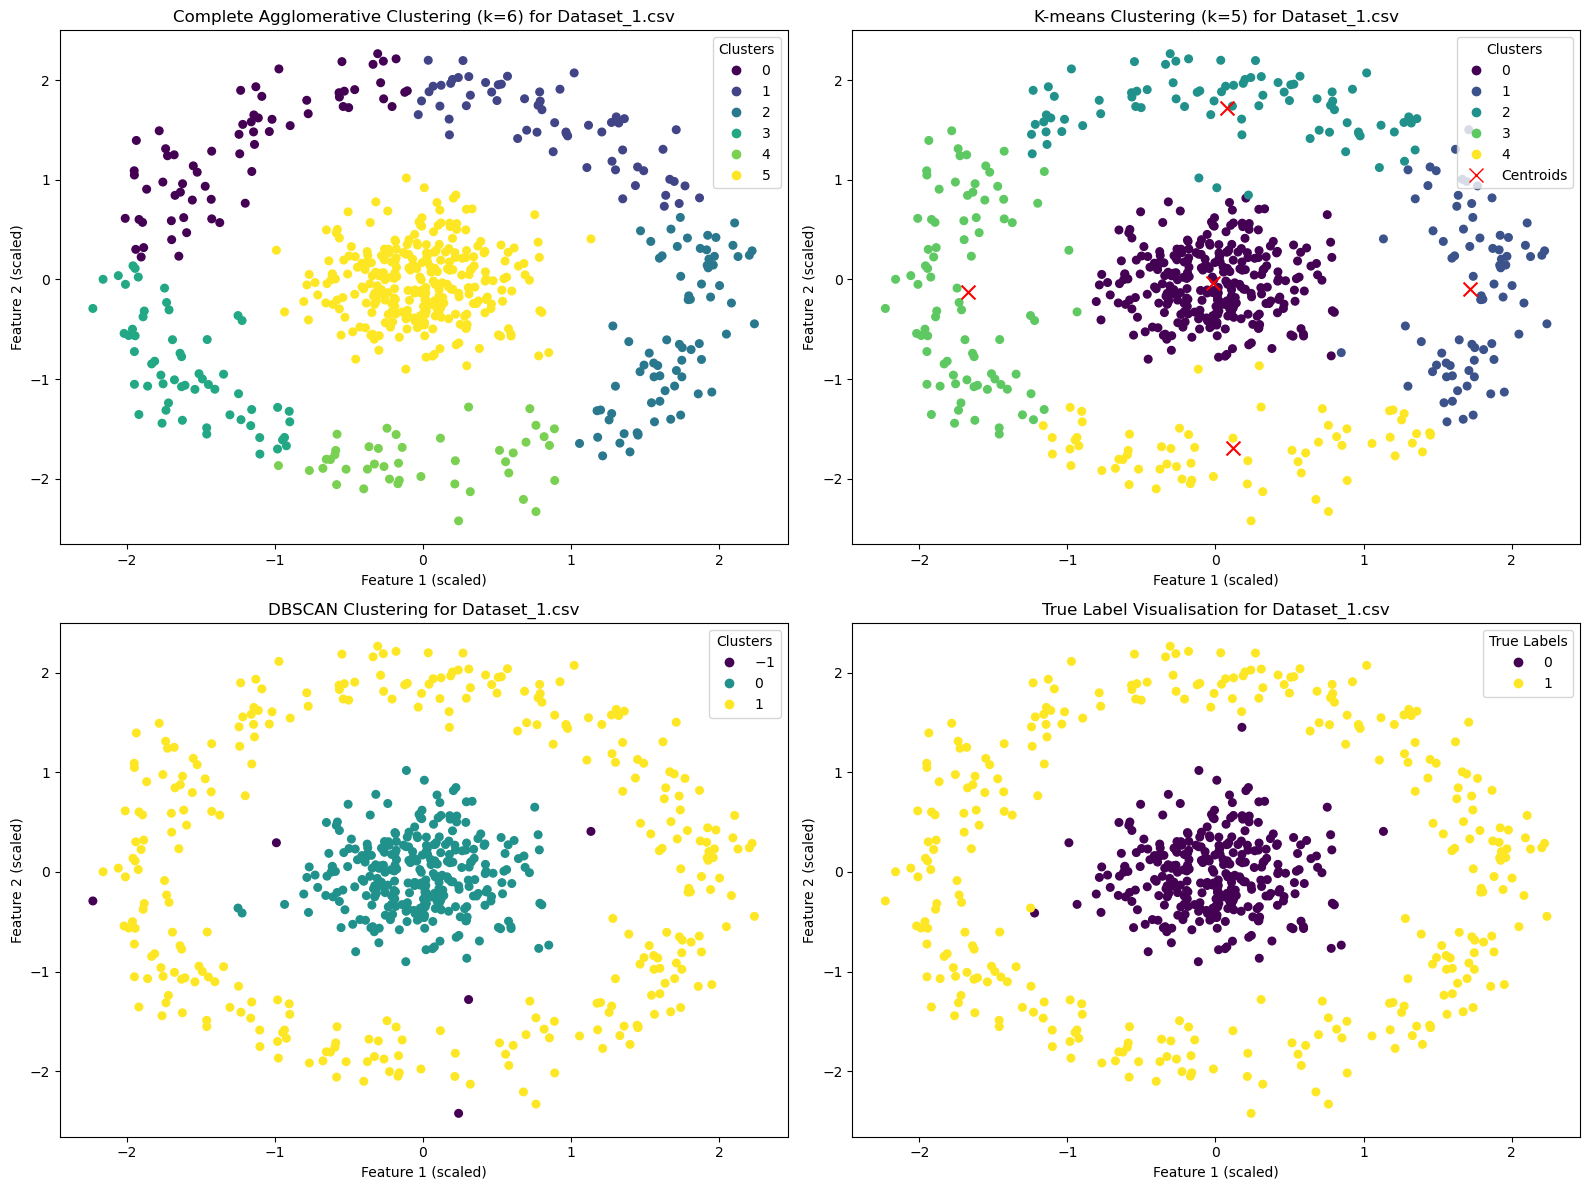

In [109]:
AG_k = 6
AG_Method = 'complete'

# Create the 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Agglomerative Clustering Plot
agg_final = AgglomerativeClustering(n_clusters=AG_k, linkage=AG_Method)
agg_labels = agg_final.fit_predict(X_scaled)
sc0 = axes[0, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=agg_labels, cmap='viridis', s=30)
axes[0, 0].set_title(f"Complete Agglomerative Clustering (k={AG_k}) for {file}")
axes[0, 0].set_xlabel("Feature 1 (scaled)")
axes[0, 0].set_ylabel("Feature 2 (scaled)")
handles0, labels0 = sc0.legend_elements()
axes[0, 0].legend(handles0, labels0, title="Clusters")

# 2. K-means Clustering Plot
km_final = KMeans(n_clusters=Kmeans_k, random_state=42)
km_labels = km_final.fit_predict(X_scaled)
sc1 = axes[0, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=km_labels, cmap='viridis', s=30)
axes[0, 1].scatter(km_final.cluster_centers_[:, 0], km_final.cluster_centers_[:, 1],
                   s=100, c='red', marker='x', label='Centroids')
axes[0, 1].set_title(f"K-means Clustering (k={Kmeans_k}) for {file}")
axes[0, 1].set_xlabel("Feature 1 (scaled)")
axes[0, 1].set_ylabel("Feature 2 (scaled)")
handles1, labels1 = sc1.legend_elements()
centroid_handle = plt.Line2D([], [], marker='x', color='red', linestyle='None', markersize=10, label='Centroids')
axes[0, 1].legend(handles=handles1 + [centroid_handle],
                  labels=list(labels1) + ['Centroids'], title="Clusters")


# 3. DBSCAN Clustering Plot
#dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
dbscan = DBSCAN(eps=0.3, min_samples=3) #Parameters set manually here
db_labels = dbscan.fit_predict(X_scaled)
sc2 = axes[1, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=db_labels, cmap='viridis', s=30)
axes[1, 0].set_title(f"DBSCAN Clustering for {file}")
axes[1, 0].set_xlabel("Feature 1 (scaled)")
axes[1, 0].set_ylabel("Feature 2 (scaled)")
handles2, labels2 = sc2.legend_elements()
axes[1, 0].legend(handles2, labels2, title="Clusters")

# 4. True Label Visualisation Plot
if len(np.unique(true_labels)) > 1:
    sc3 = axes[1, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=true_labels, cmap='viridis', s=30)
    axes[1, 1].set_title(f"True Label Visualisation for {file}")
    axes[1, 1].set_xlabel("Feature 1 (scaled)")
    axes[1, 1].set_ylabel("Feature 2 (scaled)")
    handles3, labels3 = sc3.legend_elements()
    axes[1, 1].legend(handles3, labels3, title="True Labels")
else:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


Here we can see that dataset 1 consists of one central spherical cluster and a well-separated outer ring-shaped cluster, both of which are roughly of constant density. Thus the DBScan clustering method is most effective as classifying the datapoints, only identified 5 points as noise on the graph (on all graph legends, -1 refers to noise points). On the contrary, k-means and hierachical clustering both struggle to effectively classify our data. This is because the distances between datapoints vary quite a bit throughout the plot, thus its hard for hierarchical to have one outer cluster of the full ring without incorrectly including the inner data in the same cluster. The K-Means algorithm also as the clusters are not even/spherical in shape or well separated so it cannot identify individual clusters properly. 

# Dataset 2

In [110]:
file = 'Dataset_2.csv'
print(f"Processing dataset: {file}")

# Construct full file path and load the CSV using pandas.
file_path = os.path.join(folder_path, file)

dataset = pd.read_csv(file_path, header=None)

print("Original shape:", dataset.shape)

# Split up vector columns
dataset = split_vector_columns(dataset)
print("Processed shape:", dataset.shape)

# Convert dataset to a numpy array
data = dataset.values

# Select the data for cluster
X = data[:, :-1]
true_labels = data[:, -1]

# Standardise the data to centre it at the origin
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hierarchical Clustering Optimisation

# Determine the optimal number of clusters and hierarchical clustering method by iterating k in range 2 -> 11 and determining the optimal k-value based on the highest silhouette score obtained
silhouette_scores0 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='average')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores0.append(score)
optimal_k = np.argmax(silhouette_scores0) + 2 
print(f"Optimal number of clusters (Agglomerative, average linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores0[optimal_k-2]:.3f}")

silhouette_scores1 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='single')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores1.append(score)
optimal_k = np.argmax(silhouette_scores1) + 2  
print(f"Optimal number of clusters (Agglomerative, single linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores1[optimal_k-2]:.3f}")

silhouette_scores2 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='complete')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores2.append(score)
optimal_k = np.argmax(silhouette_scores2) + 2  
print(f"Optimal number of clusters (Agglomerative, complete linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores2[optimal_k-2]:.3f}")


# K-Means Clustering Optimisation

# Same methodology as for hierarchical clustering optimisation

silhouette_scores3 = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores3.append(score)
Kmeans_k = np.argmax(silhouette_scores3) + 2  
print(f"Optimal number of clusters (K-means) for {file}: {Kmeans_k} " \
      f"with silhouette score: {silhouette_scores3[Kmeans_k-2]:.3f}")

# DBScan, parameters are again with an iterative method but this time over two parameters

# Define ranges for eps and min_samples to iterate over
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
min_samples_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# List of results for each iteration (eps, min_samples, silhouette_score)
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)

        # Only calc score for iterations with >1 cluster group

        unique_labels = np.unique(labels)
        if len(unique_labels) > 1 and (len(unique_labels) > 2 or -1 not in unique_labels): 
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1  #If only 1 cluster is found (same as original dataset)
        dbscan_results.append((eps, min_samples, score))

# Identify the optimal parameters (with the highest silhouette score)
best_params = max(dbscan_results, key=lambda x: x[2])
print(f"Optimal DBSCAN parameters for {file}: eps = {best_params[0]}, min_samples = {best_params[1]}, silhouette score = {best_params[2]:.3f}")



Processing dataset: Dataset_2.csv
Original shape: (270, 1)
Processed shape: (270, 3)
Optimal number of clusters (Agglomerative, average linkage) for Dataset_2.csv: 3 with silhouette score: 0.752
Optimal number of clusters (Agglomerative, single linkage) for Dataset_2.csv: 4 with silhouette score: 0.687
Optimal number of clusters (Agglomerative, complete linkage) for Dataset_2.csv: 3 with silhouette score: 0.752
Optimal number of clusters (K-means) for Dataset_2.csv: 3 with silhouette score: 0.752
Optimal DBSCAN parameters for Dataset_2.csv: eps = 0.4, min_samples = 9, silhouette score = 0.706


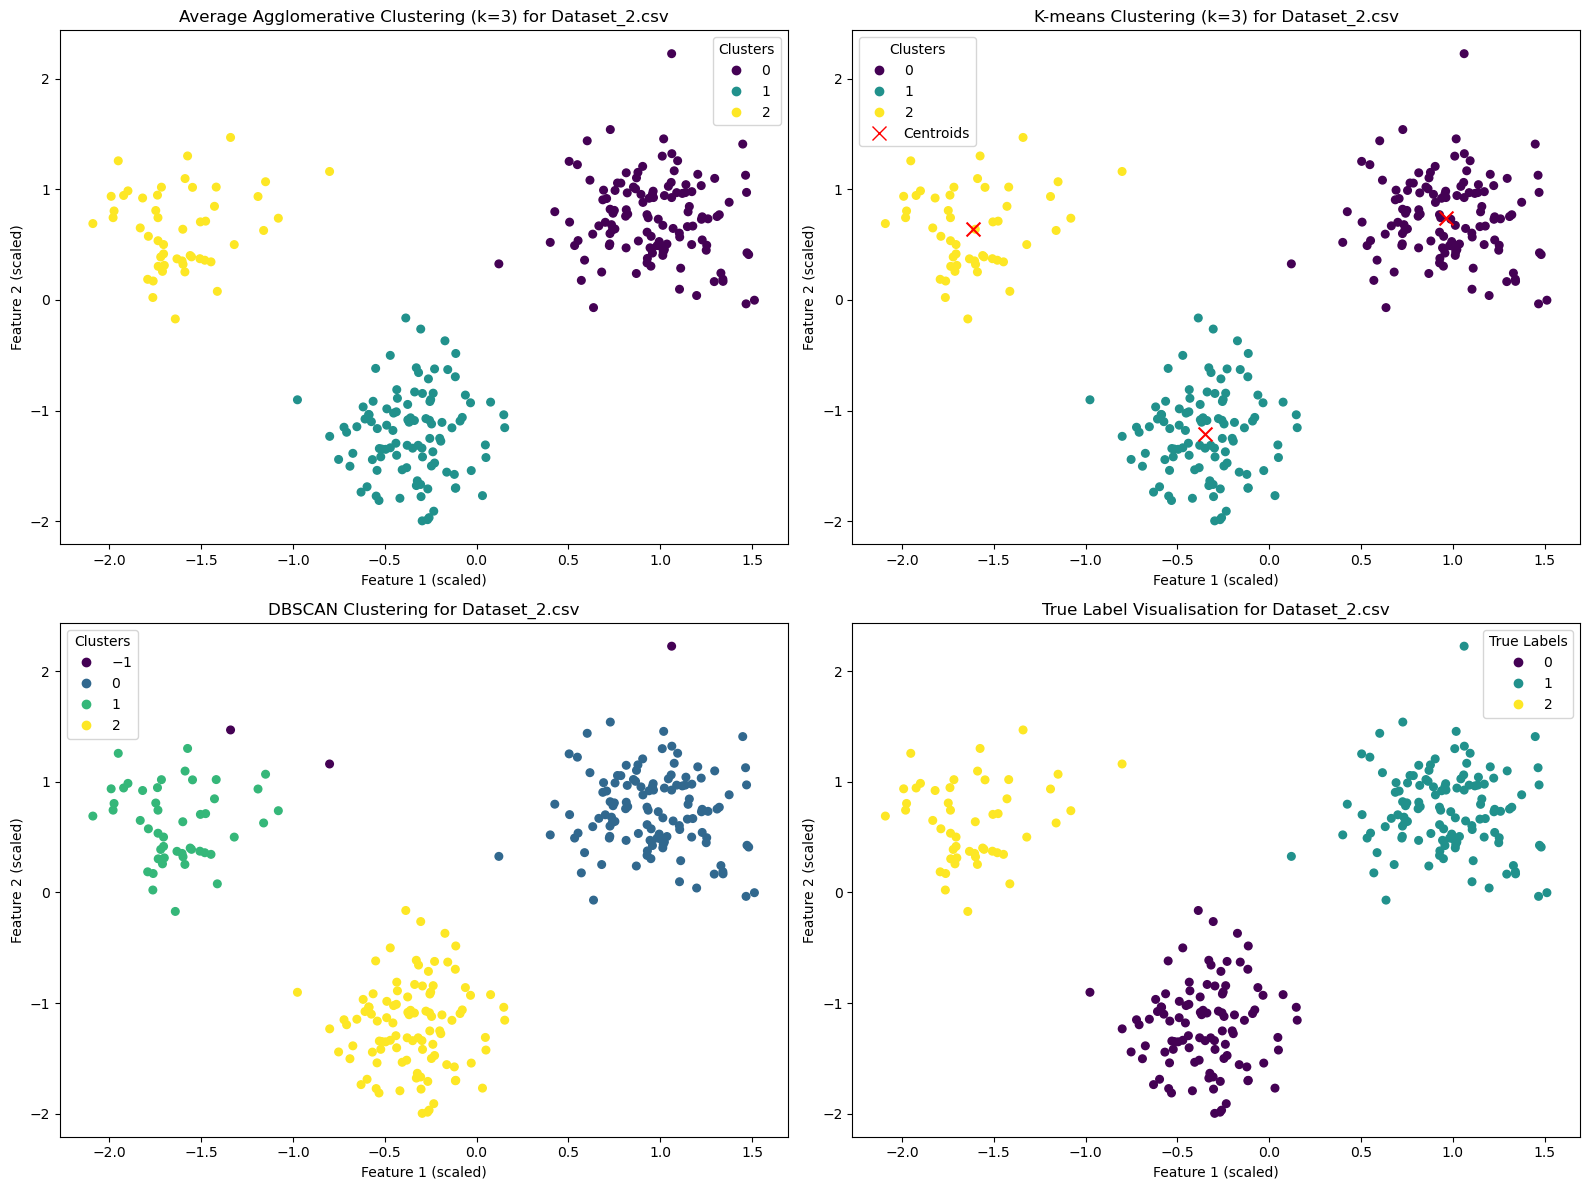

In [111]:
AG_k = 3
AG_Method = 'average'

# Create the 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Agglomerative Clustering Plot
agg_final = AgglomerativeClustering(n_clusters=AG_k, linkage=AG_Method)
agg_labels = agg_final.fit_predict(X_scaled)
sc0 = axes[0, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=agg_labels, cmap='viridis', s=30)
axes[0, 0].set_title(f"Average Agglomerative Clustering (k={AG_k}) for {file}")
axes[0, 0].set_xlabel("Feature 1 (scaled)")
axes[0, 0].set_ylabel("Feature 2 (scaled)")
handles0, labels0 = sc0.legend_elements()
axes[0, 0].legend(handles0, labels0, title="Clusters")

# 2. K-means Clustering Plot
km_final = KMeans(n_clusters=Kmeans_k, random_state=42)
km_labels = km_final.fit_predict(X_scaled)
sc1 = axes[0, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=km_labels, cmap='viridis', s=30)
axes[0, 1].scatter(km_final.cluster_centers_[:, 0], km_final.cluster_centers_[:, 1],
                   s=100, c='red', marker='x', label='Centroids')
axes[0, 1].set_title(f"K-means Clustering (k={Kmeans_k}) for {file}")
axes[0, 1].set_xlabel("Feature 1 (scaled)")
axes[0, 1].set_ylabel("Feature 2 (scaled)")
handles1, labels1 = sc1.legend_elements()
centroid_handle = plt.Line2D([], [], marker='x', color='red', linestyle='None', markersize=10, label='Centroids')
axes[0, 1].legend(handles=handles1 + [centroid_handle],
                  labels=list(labels1) + ['Centroids'], title="Clusters")

# 3. DBSCAN Clustering Plot
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
db_labels = dbscan.fit_predict(X_scaled)
sc2 = axes[1, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=db_labels, cmap='viridis', s=30)
axes[1, 0].set_title(f"DBSCAN Clustering for {file}")
axes[1, 0].set_xlabel("Feature 1 (scaled)")
axes[1, 0].set_ylabel("Feature 2 (scaled)")
handles2, labels2 = sc2.legend_elements()
axes[1, 0].legend(handles2, labels2, title="Clusters")

# 4. True Label Visualisation Plot
if len(np.unique(true_labels)) > 1:
    sc3 = axes[1, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=true_labels, cmap='viridis', s=30)
    axes[1, 1].set_title(f"True Label Visualisation for {file}")
    axes[1, 1].set_xlabel("Feature 1 (scaled)")
    axes[1, 1].set_ylabel("Feature 2 (scaled)")
    handles3, labels3 = sc3.legend_elements()
    axes[1, 1].legend(handles3, labels3, title="True Labels")
else:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


Data set 2 containts 3 clusters of data which are well separated and quite spherical in shape, so all three algorithms are able to effectively cluster the data, hierarchical and K-means doing so perfectly. We can see that the silhouette scores for hierarchical clustering are both 0.752 whether using complete or average linkage, single likely being slightly worse as there are some datapoints which stick further out in each cluster, and could likely have been incorrectly identified when using single linkage. This is also why three of these more isolated datapoints were incorrectly identified as noise by the DBScan algorithm. 

# Dataset 3

In [112]:

file = 'Dataset_3.csv'
print(f"Processing dataset: {file}")

# Construct full file path and load the CSV using pandas.
file_path = os.path.join(folder_path, file)

dataset = pd.read_csv(file_path, header=None)

print("Original shape:", dataset.shape)

# Split up vector columns
dataset = split_vector_columns(dataset)
print("Processed shape:", dataset.shape)

# Convert dataset to a numpy array
data = dataset.values

# Select the data for cluster
X = data[:, :-1]
true_labels = data[:, -1]

# Standardise the data to centre it at the origin
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hierarchical Clustering Optimisation

# Determine the optimal number of clusters and hierarchical clustering method by iterating k in range 2 -> 11 and determining the optimal k-value based on the highest silhouette score obtained
silhouette_scores0 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='average')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores0.append(score)
optimal_k = np.argmax(silhouette_scores0) + 2 
print(f"Optimal number of clusters (Agglomerative, average linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores0[optimal_k-2]:.3f}")

silhouette_scores1 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='single')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores1.append(score)
optimal_k = np.argmax(silhouette_scores1) + 2  
print(f"Optimal number of clusters (Agglomerative, single linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores1[optimal_k-2]:.3f}")

silhouette_scores2 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='complete')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores2.append(score)
optimal_k = np.argmax(silhouette_scores2) + 2  
print(f"Optimal number of clusters (Agglomerative, complete linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores2[optimal_k-2]:.3f}")


# K-Means Clustering Optimisation

# Same methodology as for hierarchical clustering optimisation

silhouette_scores3 = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores3.append(score)
Kmeans_k = np.argmax(silhouette_scores3) + 2  
print(f"Optimal number of clusters (K-means) for {file}: {Kmeans_k} " \
      f"with silhouette score: {silhouette_scores3[Kmeans_k-2]:.3f}")

# DBScan, parameters are again with an iterative method but this time over two parameters

# Define ranges for eps and min_samples to iterate over
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
min_samples_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# List of results for each iteration (eps, min_samples, silhouette_score)
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)

        # Only calc score for iterations with >1 cluster group

        unique_labels = np.unique(labels)
        if len(unique_labels) > 1 and (len(unique_labels) > 2 or -1 not in unique_labels): 
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1  #If only 1 cluster is found (same as original dataset)
        dbscan_results.append((eps, min_samples, score))

# Identify the optimal parameters (with the highest silhouette score)
best_params = max(dbscan_results, key=lambda x: x[2])
print(f"Optimal DBSCAN parameters for {file}: eps = {best_params[0]}, min_samples = {best_params[1]}, silhouette score = {best_params[2]:.3f}")



Processing dataset: Dataset_3.csv
Original shape: (600, 1)
Processed shape: (600, 3)
Optimal number of clusters (Agglomerative, average linkage) for Dataset_3.csv: 3 with silhouette score: 0.568
Optimal number of clusters (Agglomerative, single linkage) for Dataset_3.csv: 2 with silhouette score: 0.269
Optimal number of clusters (Agglomerative, complete linkage) for Dataset_3.csv: 3 with silhouette score: 0.582
Optimal number of clusters (K-means) for Dataset_3.csv: 3 with silhouette score: 0.583
Optimal DBSCAN parameters for Dataset_3.csv: eps = 0.4, min_samples = 9, silhouette score = 0.443


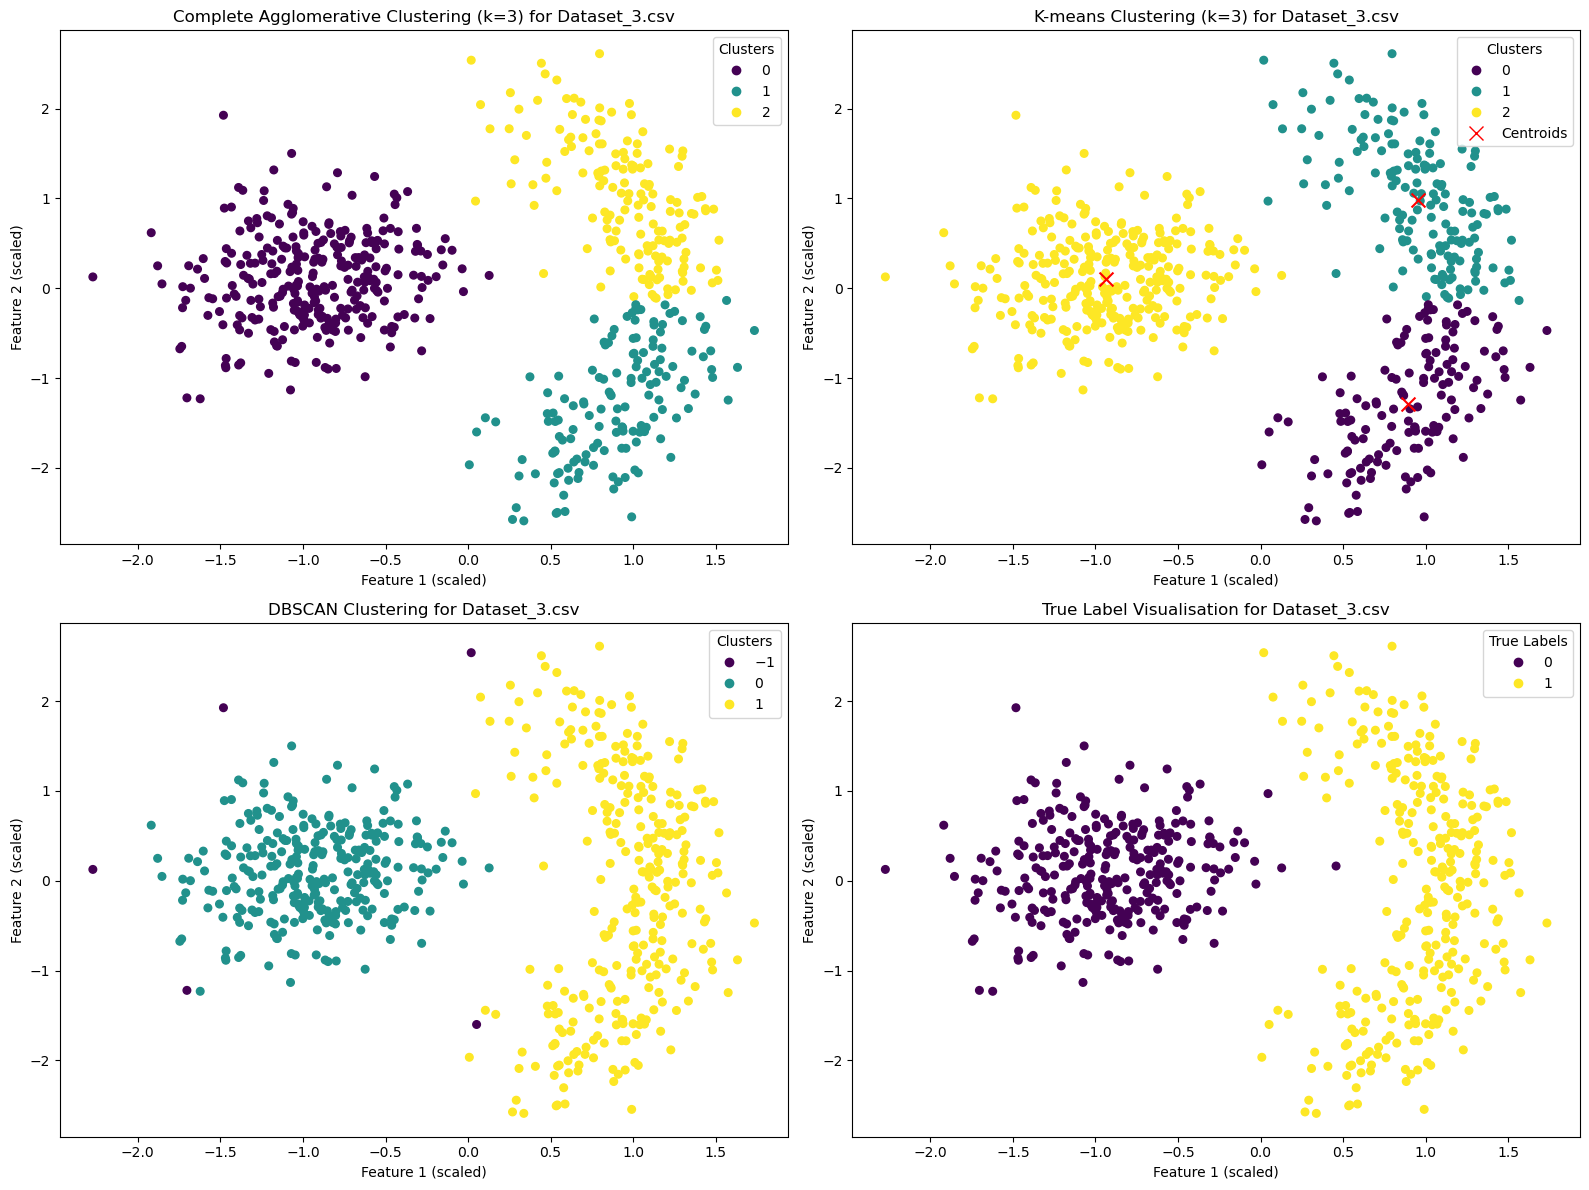

In [113]:
AG_k = 3
AG_Method = 'complete'

# Create the 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Agglomerative Clustering Plot
agg_final = AgglomerativeClustering(n_clusters=AG_k, linkage=AG_Method)
agg_labels = agg_final.fit_predict(X_scaled)
sc0 = axes[0, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=agg_labels, cmap='viridis', s=30)
axes[0, 0].set_title(f"Complete Agglomerative Clustering (k={AG_k}) for {file}")
axes[0, 0].set_xlabel("Feature 1 (scaled)")
axes[0, 0].set_ylabel("Feature 2 (scaled)")
handles0, labels0 = sc0.legend_elements()
axes[0, 0].legend(handles0, labels0, title="Clusters")

# 2. K-means Clustering Plot
km_final = KMeans(n_clusters=Kmeans_k, random_state=42)
km_labels = km_final.fit_predict(X_scaled)
sc1 = axes[0, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=km_labels, cmap='viridis', s=30)
# Plot centroids
axes[0, 1].scatter(km_final.cluster_centers_[:, 0], km_final.cluster_centers_[:, 1],
                   s=100, c='red', marker='x', label='Centroids')
axes[0, 1].set_title(f"K-means Clustering (k={Kmeans_k}) for {file}")
axes[0, 1].set_xlabel("Feature 1 (scaled)")
axes[0, 1].set_ylabel("Feature 2 (scaled)")
handles1, labels1 = sc1.legend_elements()
centroid_handle = plt.Line2D([], [], marker='x', color='red', linestyle='None', markersize=10, label='Centroids')
axes[0, 1].legend(handles=handles1 + [centroid_handle],
                  labels=list(labels1) + ['Centroids'], title="Clusters")

# 3. DBSCAN Clustering Plot
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
db_labels = dbscan.fit_predict(X_scaled)
sc2 = axes[1, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=db_labels, cmap='viridis', s=30)
axes[1, 0].set_title(f"DBSCAN Clustering for {file}")
axes[1, 0].set_xlabel("Feature 1 (scaled)")
axes[1, 0].set_ylabel("Feature 2 (scaled)")
handles2, labels2 = sc2.legend_elements()
axes[1, 0].legend(handles2, labels2, title="Clusters")

# 4. True Label Visualisation Plot
if len(np.unique(true_labels)) > 1:
    sc3 = axes[1, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=true_labels, cmap='viridis', s=30)
    axes[1, 1].set_title(f"True Label Visualisation for {file}")
    axes[1, 1].set_xlabel("Feature 1 (scaled)")
    axes[1, 1].set_ylabel("Feature 2 (scaled)")
    handles3, labels3 = sc3.legend_elements()
    axes[1, 1].legend(handles3, labels3, title="True Labels")
else:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


Dataset 3 consists of two clusters reasonable well separated, the left being spherical in shape where the right one is more crescent shaped. K-Means struggles to fit this dataset as with 2 clusters the centroids will incorrectly identify datapoints from a cluster to which are closer to it than datapoints further out in its own cluster. Hierarchical clustering also struggles due to some data points being much further out, so with k=2 it struggles to classify the data and has one more isolated data point being in its own cluster while the the two true clusters are grouped into one. DBScan excels here as the majority of the data in each cluster is of constant density, only incorrectly identifying a few isolated datapoints as noise. It is resistant to individual points varying more in distance from other points.   

# Dataset 4

In [114]:
file = 'Dataset_4.csv'
print(f"Processing dataset: {file}")

# Construct full file path and load the CSV using pandas.
file_path = os.path.join(folder_path, file)

dataset = pd.read_csv(file_path, header=None)

print("Original shape:", dataset.shape)

# Split up vector columns
dataset = split_vector_columns(dataset)
print("Processed shape:", dataset.shape)

# Convert dataset to a numpy array
data = dataset.values

# Select the data for cluster
X = data[:, :-1]
true_labels = data[:, -1]

# Standardise the data to centre it at the origin
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hierarchical Clustering Optimisation

# Determine the optimal number of clusters and hierarchical clustering method by iterating k in range 2 -> 11 and determining the optimal k-value based on the highest silhouette score obtained
silhouette_scores0 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='average')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores0.append(score)
optimal_k = np.argmax(silhouette_scores0) + 2 
print(f"Optimal number of clusters (Agglomerative, average linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores0[optimal_k-2]:.3f}")

silhouette_scores1 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='single')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores1.append(score)
optimal_k = np.argmax(silhouette_scores1) + 2  
print(f"Optimal number of clusters (Agglomerative, single linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores1[optimal_k-2]:.3f}")

silhouette_scores2 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='complete')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores2.append(score)
optimal_k = np.argmax(silhouette_scores2) + 2  
print(f"Optimal number of clusters (Agglomerative, complete linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores2[optimal_k-2]:.3f}")


# K-Means Clustering Optimisation

# Same methodology as for hierarchical clustering optimisation

silhouette_scores3 = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores3.append(score)
Kmeans_k = np.argmax(silhouette_scores3) + 2  
print(f"Optimal number of clusters (K-means) for {file}: {Kmeans_k} " \
      f"with silhouette score: {silhouette_scores3[Kmeans_k-2]:.3f}")

# DBScan, parameters are again with an iterative method but this time over two parameters

# Define ranges for eps and min_samples to iterate over
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
min_samples_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# List of results for each iteration (eps, min_samples, silhouette_score)
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)

        # Only calc score for iterations with >1 cluster group

        unique_labels = np.unique(labels)
        if len(unique_labels) > 1 and (len(unique_labels) > 2 or -1 not in unique_labels): 
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1  #If only 1 cluster is found (same as original dataset)
        dbscan_results.append((eps, min_samples, score))

# Identify the optimal parameters (with the highest silhouette score)
best_params = max(dbscan_results, key=lambda x: x[2])
print(f"Optimal DBSCAN parameters for {file}: eps = {best_params[0]}, min_samples = {best_params[1]}, silhouette score = {best_params[2]:.3f}")



Processing dataset: Dataset_4.csv
Original shape: (600, 1)
Processed shape: (600, 3)
Optimal number of clusters (Agglomerative, average linkage) for Dataset_4.csv: 3 with silhouette score: 0.667
Optimal number of clusters (Agglomerative, single linkage) for Dataset_4.csv: 4 with silhouette score: 0.646
Optimal number of clusters (Agglomerative, complete linkage) for Dataset_4.csv: 3 with silhouette score: 0.660
Optimal number of clusters (K-means) for Dataset_4.csv: 3 with silhouette score: 0.653
Optimal DBSCAN parameters for Dataset_4.csv: eps = 0.5, min_samples = 2, silhouette score = 0.655


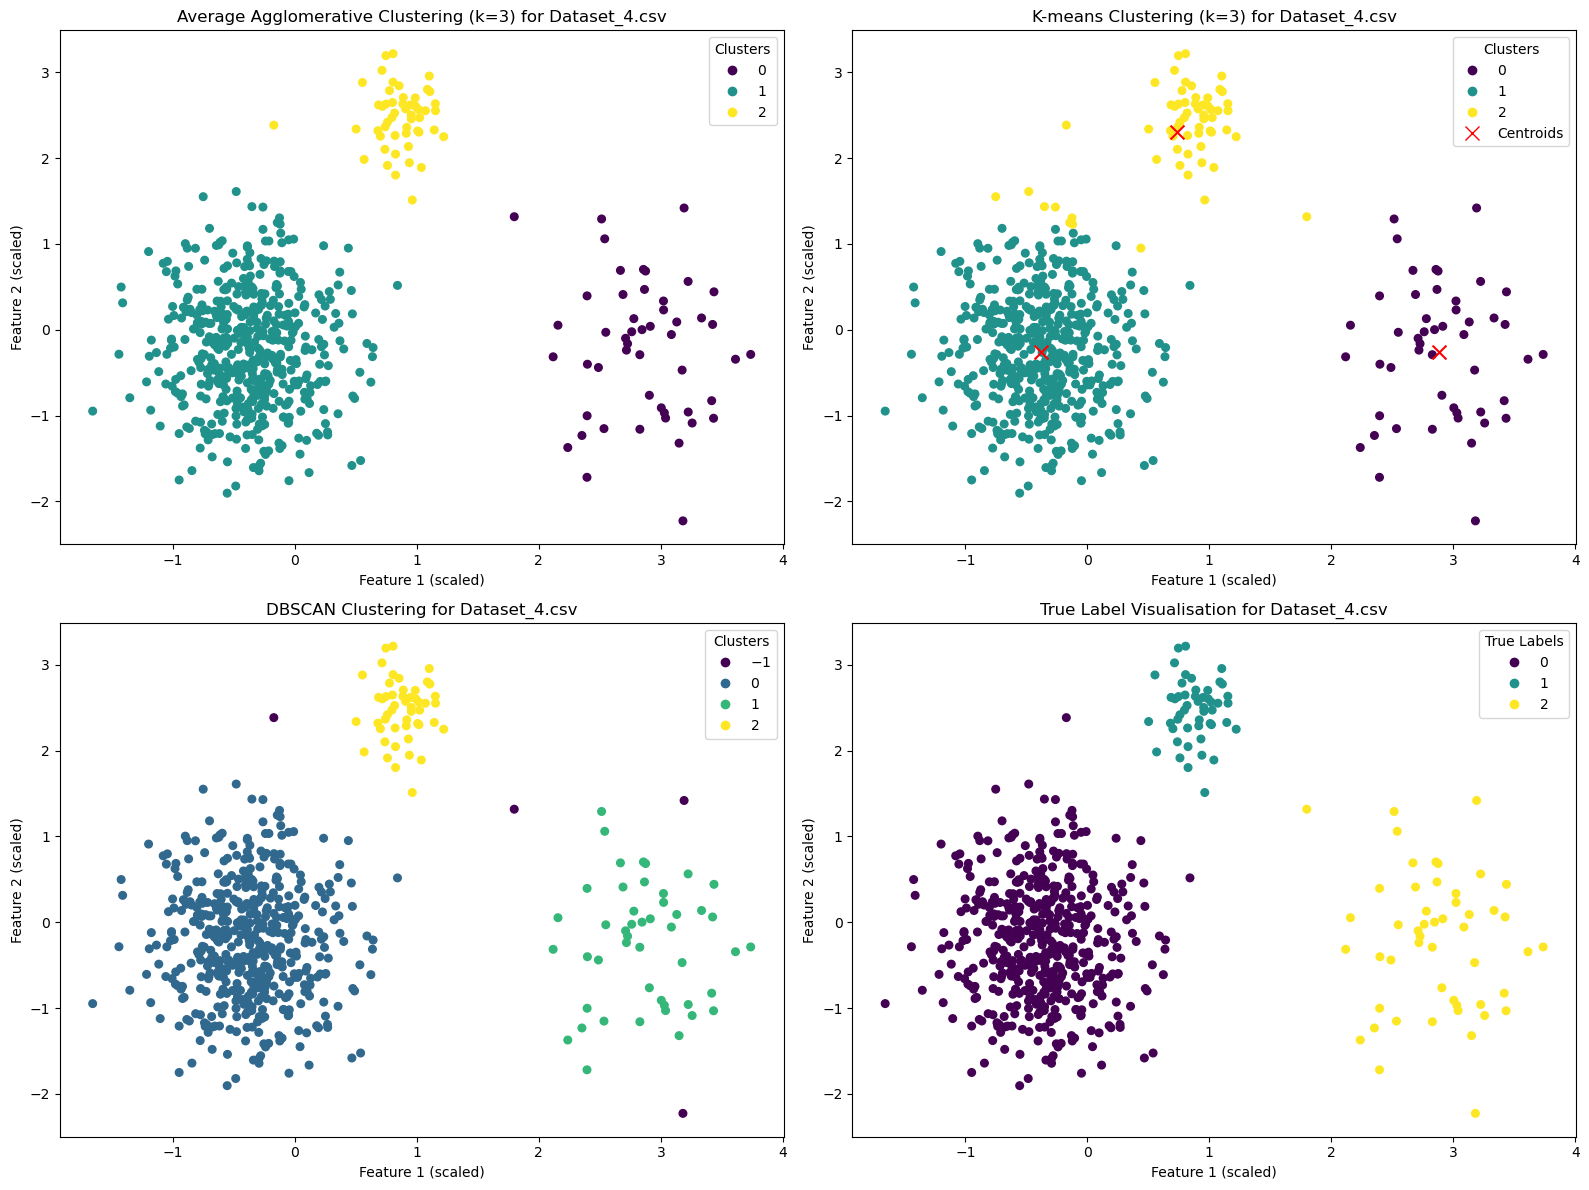

In [115]:
AG_k = 3
AG_Method = 'average'

# Create the 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Agglomerative Clustering Plot
agg_final = AgglomerativeClustering(n_clusters=AG_k, linkage=AG_Method)
agg_labels = agg_final.fit_predict(X_scaled)
sc0 = axes[0, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=agg_labels, cmap='viridis', s=30)
axes[0, 0].set_title(f"Average Agglomerative Clustering (k={AG_k}) for {file}")
axes[0, 0].set_xlabel("Feature 1 (scaled)")
axes[0, 0].set_ylabel("Feature 2 (scaled)")
handles0, labels0 = sc0.legend_elements()
axes[0, 0].legend(handles0, labels0, title="Clusters")

# 2. K-means Clustering Plot
km_final = KMeans(n_clusters=Kmeans_k, random_state=42)
km_labels = km_final.fit_predict(X_scaled)
sc1 = axes[0, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=km_labels, cmap='viridis', s=30)
axes[0, 1].scatter(km_final.cluster_centers_[:, 0], km_final.cluster_centers_[:, 1],
                   s=100, c='red', marker='x', label='Centroids')
axes[0, 1].set_title(f"K-means Clustering (k={Kmeans_k}) for {file}")
axes[0, 1].set_xlabel("Feature 1 (scaled)")
axes[0, 1].set_ylabel("Feature 2 (scaled)")
handles1, labels1 = sc1.legend_elements()
centroid_handle = plt.Line2D([], [], marker='x', color='red', linestyle='None', markersize=10, label='Centroids')
axes[0, 1].legend(handles=handles1 + [centroid_handle],
                  labels=list(labels1) + ['Centroids'], title="Clusters")

# 3. DBSCAN Clustering Plot
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
db_labels = dbscan.fit_predict(X_scaled)
sc2 = axes[1, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=db_labels, cmap='viridis', s=30)
axes[1, 0].set_title(f"DBSCAN Clustering for {file}")
axes[1, 0].set_xlabel("Feature 1 (scaled)")
axes[1, 0].set_ylabel("Feature 2 (scaled)")
handles2, labels2 = sc2.legend_elements()
axes[1, 0].legend(handles2, labels2, title="Clusters")

# 4. True Label Visualisation Plot
if len(np.unique(true_labels)) > 1:
    sc3 = axes[1, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=true_labels, cmap='viridis', s=30)
    axes[1, 1].set_title(f"True Label Visualisation for {file}")
    axes[1, 1].set_xlabel("Feature 1 (scaled)")
    axes[1, 1].set_ylabel("Feature 2 (scaled)")
    handles3, labels3 = sc3.legend_elements()
    axes[1, 1].legend(handles3, labels3, title="True Labels")
else:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


Dataset 4 contains 3 well-separated spherical clusters of varying density. Despite the bottom-right cluster being less dense than the other two, all algorithms still perform quite well in clustering the data. Hierarchical and K-Means both perfectly identify all data points, with hierarchical using average linkage for the highest silhouette score. With single-linkage hierarchical struggles again due to some more isolated data points negatively impacting the clustering, however with average linkage these anomalous datapoints don't affect the clustering. With DBScan 4 of these more isolated points are incorrectly identified as noise, but DBScan still manages to correctly identify all three separate clusters, despite their varying densities. This is because they are still rather well separated.

# Dataset 5

In [104]:
file = 'Dataset_5.csv'
print(f"Processing dataset: {file}")

# Construct full file path and load the CSV using pandas.
file_path = os.path.join(folder_path, file)

dataset = pd.read_csv(file_path, header=None)

print("Original shape:", dataset.shape)

# Split up vector columns
dataset = split_vector_columns(dataset)
print("Processed shape:", dataset.shape)

# Convert dataset to a numpy array
data = dataset.values

# Select the data for cluster
X = data[:, :-1]
true_labels = data[:, -1]

# Standardise the data to centre it at the origin
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hierarchical Clustering Optimisation

# Determine the optimal number of clusters and hierarchical clustering method by iterating k in range 2 -> 11 and determining the optimal k-value based on the highest silhouette score obtained
silhouette_scores0 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='average')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores0.append(score)
optimal_k = np.argmax(silhouette_scores0) + 2 
print(f"Optimal number of clusters (Agglomerative, average linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores0[optimal_k-2]:.3f}")

silhouette_scores1 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='single')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores1.append(score)
optimal_k = np.argmax(silhouette_scores1) + 2  
print(f"Optimal number of clusters (Agglomerative, single linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores1[optimal_k-2]:.3f}")

silhouette_scores2 = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='complete')
    labels = agg.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores2.append(score)
optimal_k = np.argmax(silhouette_scores2) + 2  
print(f"Optimal number of clusters (Agglomerative, complete linkage) for {file}: {optimal_k} " \
      f"with silhouette score: {silhouette_scores2[optimal_k-2]:.3f}")


# K-Means Clustering Optimisation

# Same methodology as for hierarchical clustering optimisation

silhouette_scores3 = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores3.append(score)
Kmeans_k = np.argmax(silhouette_scores3) + 2  
print(f"Optimal number of clusters (K-means) for {file}: {Kmeans_k} " \
      f"with silhouette score: {silhouette_scores3[Kmeans_k-2]:.3f}")

# DBScan, parameters are again with an iterative method but this time over two parameters

# Define ranges for eps and min_samples to iterate over
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
min_samples_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# List of results for each iteration (eps, min_samples, silhouette_score)
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)

        # Only calc score for iterations with >1 cluster group

        unique_labels = np.unique(labels)
        if len(unique_labels) > 1 and (len(unique_labels) > 2 or -1 not in unique_labels): 
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1  #If only 1 cluster is found (same as original dataset)
        dbscan_results.append((eps, min_samples, score))

# Identify the optimal parameters (with the highest silhouette score)
best_params = max(dbscan_results, key=lambda x: x[2])
print(f"Optimal DBSCAN parameters for {file}: eps = {best_params[0]}, min_samples = {best_params[1]}, silhouette score = {best_params[2]:.3f}")


Processing dataset: Dataset_5.csv
Original shape: (850, 1)
Processed shape: (850, 3)
Optimal number of clusters (Agglomerative, average linkage) for Dataset_5.csv: 6 with silhouette score: 0.651
Optimal number of clusters (Agglomerative, single linkage) for Dataset_5.csv: 3 with silhouette score: 0.457
Optimal number of clusters (Agglomerative, complete linkage) for Dataset_5.csv: 8 with silhouette score: 0.605
Optimal number of clusters (K-means) for Dataset_5.csv: 6 with silhouette score: 0.654
Optimal DBSCAN parameters for Dataset_5.csv: eps = 0.3, min_samples = 1, silhouette score = 0.457


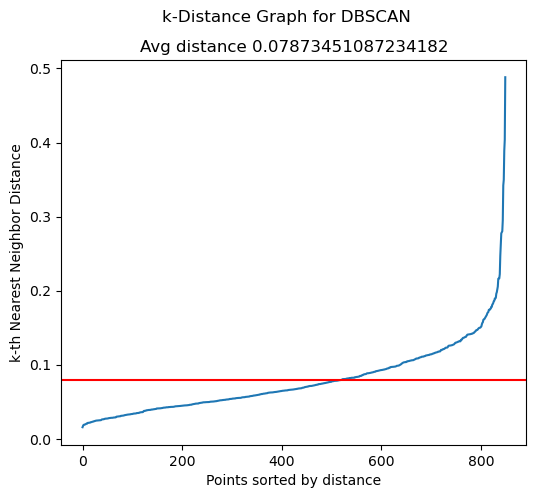

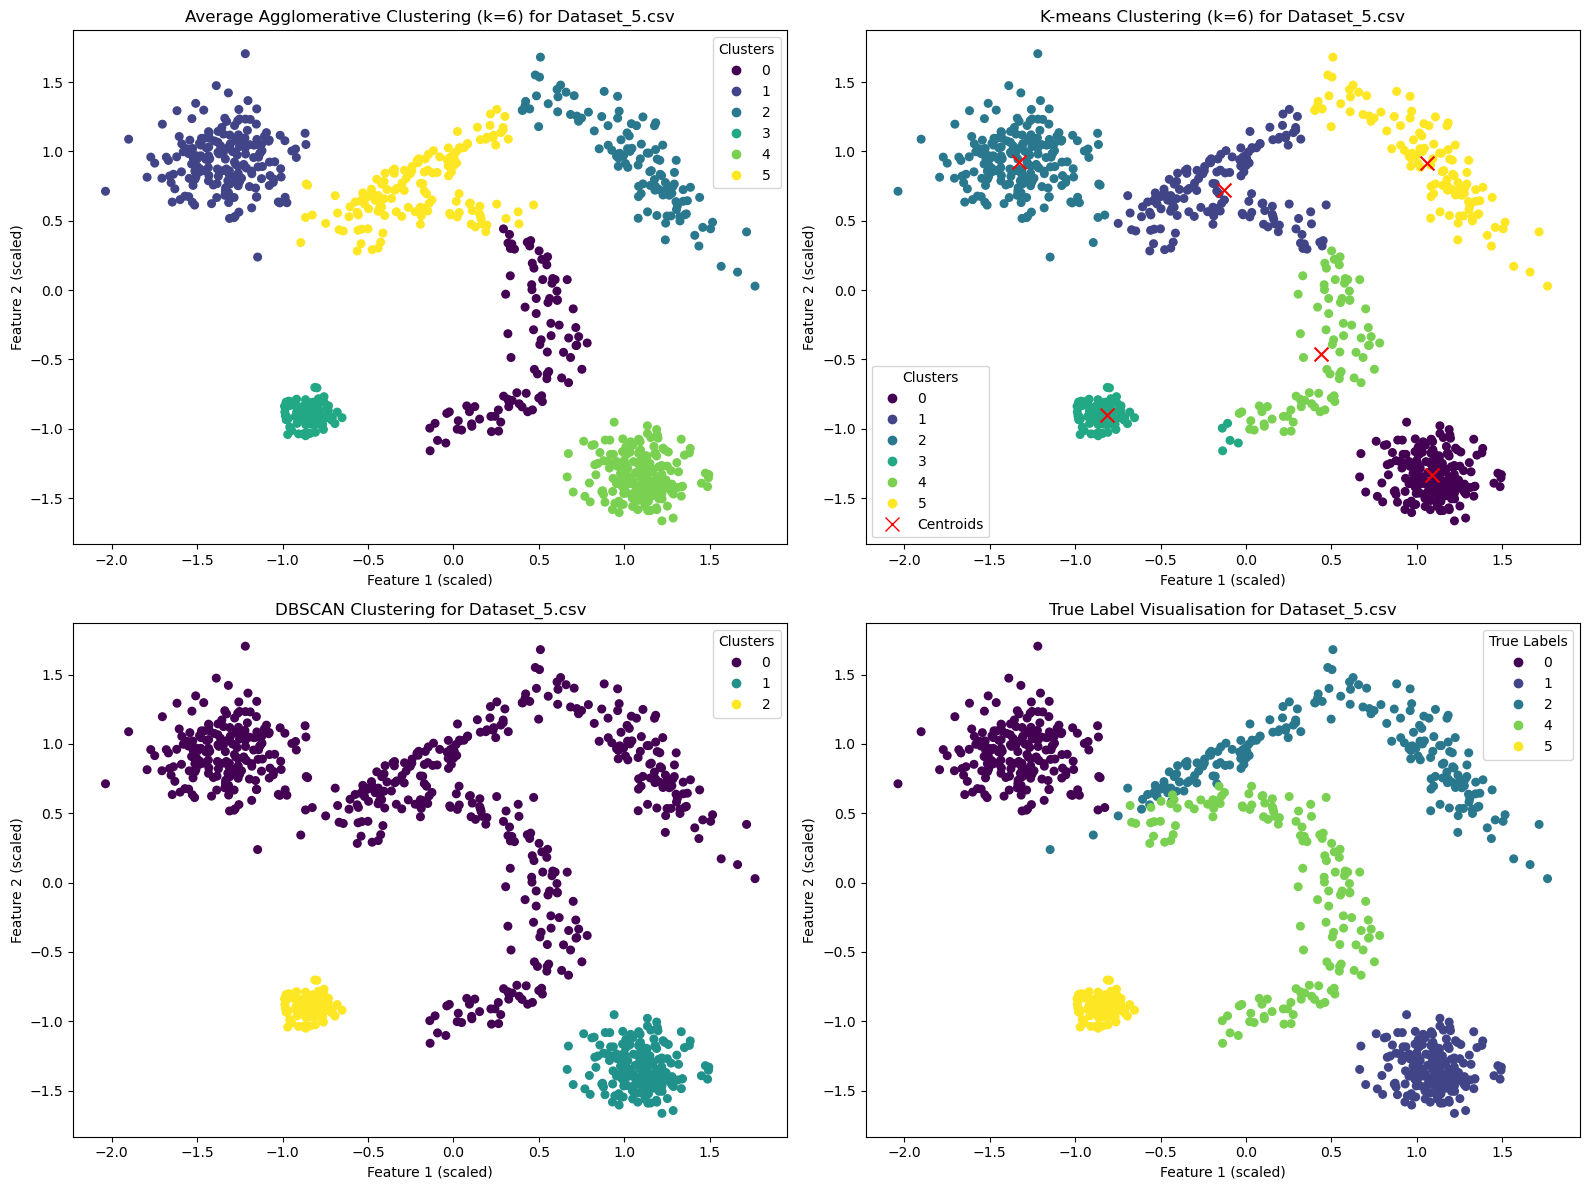

In [105]:
AG_k = 6
AG_Method = 'average'

from sklearn.neighbors import NearestNeighbors

# k-distance graph to help select eps
minpts = 6
neighbors = NearestNeighbors(n_neighbors=minpts)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
# sort distances (take the 4th nearest neighbor distance)
distances = np.sort(distances[:, minpts-1])

plt.figure(figsize=(6, 5))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-th Nearest Neighbor Distance')
plt.suptitle('k-Distance Graph for DBSCAN')
plt.axhline(y = np.mean(distances), c = "red")
plt.title("Avg distance {}".format(np.mean(distances)))


# Create the 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Agglomerative Clustering Plot
agg_final = AgglomerativeClustering(n_clusters=AG_k, linkage=AG_Method)
agg_labels = agg_final.fit_predict(X_scaled)
sc0 = axes[0, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=agg_labels, cmap='viridis', s=30)
axes[0, 0].set_title(f"Average Agglomerative Clustering (k={AG_k}) for {file}")
axes[0, 0].set_xlabel("Feature 1 (scaled)")
axes[0, 0].set_ylabel("Feature 2 (scaled)")
handles0, labels0 = sc0.legend_elements()
axes[0, 0].legend(handles0, labels0, title="Clusters")

# 2. K-means Clustering Plot
km_final = KMeans(n_clusters=Kmeans_k, random_state=42)
km_labels = km_final.fit_predict(X_scaled)
sc1 = axes[0, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=km_labels, cmap='viridis', s=30)
axes[0, 1].scatter(km_final.cluster_centers_[:, 0], km_final.cluster_centers_[:, 1],
                   s=100, c='red', marker='x', label='Centroids')
axes[0, 1].set_title(f"K-means Clustering (k={Kmeans_k}) for {file}")
axes[0, 1].set_xlabel("Feature 1 (scaled)")
axes[0, 1].set_ylabel("Feature 2 (scaled)")
handles1, labels1 = sc1.legend_elements()
centroid_handle = plt.Line2D([], [], marker='x', color='red', linestyle='None', markersize=10, label='Centroids')
axes[0, 1].legend(handles=handles1 + [centroid_handle],
                  labels=list(labels1) + ['Centroids'], title="Clusters")


# 3. DBSCAN Clustering Plot
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
#dbscan = DBSCAN(eps=np.mean(distances), min_samples=minpts)
db_labels = dbscan.fit_predict(X_scaled)
sc2 = axes[1, 0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=db_labels, cmap='viridis', s=30)
axes[1, 0].set_title(f"DBSCAN Clustering for {file}")
axes[1, 0].set_xlabel("Feature 1 (scaled)")
axes[1, 0].set_ylabel("Feature 2 (scaled)")
handles2, labels2 = sc2.legend_elements()
axes[1, 0].legend(handles2, labels2, title="Clusters")

# 4. True Label Visualisation Plot
if len(np.unique(true_labels)) > 1:
    sc3 = axes[1, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=true_labels, cmap='viridis', s=30)
    axes[1, 1].set_title(f"True Label Visualisation for {file}")
    axes[1, 1].set_xlabel("Feature 1 (scaled)")
    axes[1, 1].set_ylabel("Feature 2 (scaled)")
    handles3, labels3 = sc3.legend_elements()
    axes[1, 1].legend(handles3, labels3, title="True Labels")
else:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


Dataset 5 contains 5 individual clusters, the distribution of clusters is very uneven and they are not very well separated; although the density of them does not very so much, the bottom two clusters are more dense than the other three. The two ones in the top right quadrant also have very uneven shapes. Due to its nature, all three algorithms struggle with this dataset.

 The best results are obtained for hierarchical and K-Means using k=6, as using less clusters leads to the problematic merging of clusters similarly to as seen in the DBScan plot. With k set to 6 an additional cluster is introduced joining together some points of the two top right clusters which are too closely located to distinguish into their true clusters, but manages to identify the remaining datapoints into their true clusters quite well. DBScan groups together the top 3 clusters as they are simply too close together (with some points touching) and similar in densities for it to distinguish between them properly. 

 I did attempt different methods to optimise the DBScan parameters in an attempt to better identify the different clusters, such as using the k-distance graph to set epsilon as can be seen above, however all were unsuccessful due to the problematic nature of this dataset.
 